# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [1]:
from report import create_report_files
pull_data = False

if pull_data:
    create_report_files(
        "../../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
        "ratings-v2.xlsx",
        "pairs-v2.xlsx",
    )

### Loading and displaying the raw data

In [2]:
import pandas as pd

pairs = pd.read_excel("./pairs-v2.xlsx")
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'model_1', 'initial_distance',
       'size', 'fov_y', 'dataset_name', 'position', 'high_detail',
       'dataset', 'aspect', 'n_ratings', 'id'], dtype=object)

In [3]:
ratings = pd.read_excel("./ratings-v2.xlsx")
ratings.columns.values

array(['Unnamed: 0', 'rating', 'rating_1', 'user_id', 'pair_id',
       'rating_2', 'id'], dtype=object)

### How many ratings are there per pair?

In [4]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
0,0Qbwb7Lis9pOLUVOSIrO,1
1,0YwyBZxWsQpHsGv8LS61,1
2,0bIsWmiOeRXEyKdMrHB1,1
3,0uSshiYpzXHdIn1okZsk,1
4,0vY7sjGJiyicoohSiEQM,1
5,1DMpSYJYgWlOR38X57hm,1
6,1SUpmaSAQQNMdD8FibPB,1
7,1njZxACnAGt6T5qLMRlL,1
8,29sPSf4gbZUmlbkLou5s,1
9,2RlFF5xLe8UvS9tLxjyn,1


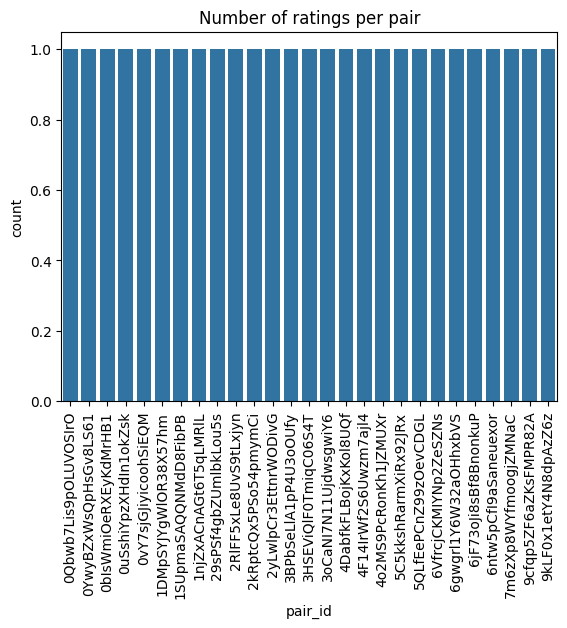

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [6]:
# Check what percentage of pairs has been covered
print(f"{df_ratings_count_computed.shape[0]}/{pairs.shape[0]} pairs have been covered. Thats {round(df_ratings_count_computed.shape[0] / pairs.shape[0] * 100, 2)}%.")

27/252 pairs have been covered. Thats 10.71%.


In [7]:
# sanity check from ratings side if all n_ratings are actually covered by actual ratings
for idx, [
    unnamed,
    rotation,
    model_2,
    model_1,
    initial_distance,
    size,
    fov_y,
    dataset_name,
    position,
    high_detail,
    dataset,
    aspect,
    n_ratings,
    id,
] in pairs.iterrows():
    if n_ratings >= 1:
        if id in ratings_count_computed:
            if not (ratings_count_computed[id] == n_ratings):
                print(f"Error! pair \"{id}\" had different n_ratings than actual rating entities {n_ratings} != {ratings_count_computed[id]}")
        else:
            print(f"Error! pair \"{id}\" had different n_ratings than actual rating entities {n_ratings} != {0}")

In [8]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

In [9]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
df_ratings_per_user

,user_id,count
1,528f3c4b-7c50-4715-bda7-f85f27317a8d,6
2,a7037b14-2e6d-4f7d-bac8-ed02d7df5329,6
0,19b57dbb-8b65-48f2-a217-3287973988cd,5
3,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,5
4,e5de31f2-fc40-4062-9135-3aba73149106,5


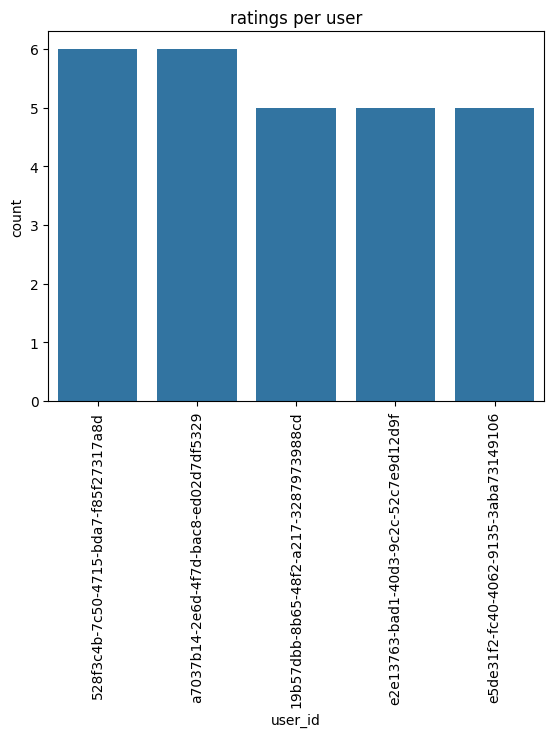

In [10]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [11]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "first",
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "second",
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,preferred,user_id
0,mcmc-truck-extended-1,False,528f3c4b-7c50-4715-bda7-f85f27317a8d
1,gaussian_pro-truck-extended-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d
2,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d
3,geo_gaussian-stump-medium-1,False,528f3c4b-7c50-4715-bda7-f85f27317a8d
4,default-stump-extended-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d
5,eagles-stump-extended-1,False,528f3c4b-7c50-4715-bda7-f85f27317a8d
6,mini_splatting-stump-high-1,False,e5de31f2-fc40-4062-9135-3aba73149106
7,gaussian_pro-stump-high-1,False,e5de31f2-fc40-4062-9135-3aba73149106
8,default-room-low-1,True,e5de31f2-fc40-4062-9135-3aba73149106
9,mcmc-room-low-1,False,e5de31f2-fc40-4062-9135-3aba73149106


In [12]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
0,default-room-extended-1,2
8,eagles-stump-high-1,2
9,eagles-stump-medium-1,2
32,mini_splatting-room-high-1,2
36,mini_splatting-stump-medium-1,2
34,mini_splatting-stump-high-1,2
18,gaussian_pro-truck-medium-1,2
15,gaussian_pro-stump-high-1,2
14,gaussian_pro-room-medium-1,2
10,eagles-truck-high-1,2


### Whats the just objectionable difference (JOD) for each approach/size?

In [13]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

preferences = np.zeros((7, 7), dtype=np.signedinteger)
index = {
    "default": 0,
    "mcmc": 1,
    "mini_splatting": 2,
    "eagles": 3,
    "mip_splatting": 4,
    "gaussian_pro": 5,
    "geo_gaussian": 6,
}

for idx, rating in ratings.iterrows():
    pair = pairs[pairs["id"] == rating["pair_id"]]
    model_1 = pair["model_1"].iloc[0].split("-")[0].replace("splats/", "")
    model_2 = pair["model_2"].iloc[0].split("-")[0].replace("splats/", "")

    if rating["rating"] == "first":
        preferences[index[model_1]][index[model_2]] = (
            preferences[index[model_1]][index[model_2]] + 1
        )
    if rating["rating"] == "second":
        preferences[index[model_2]][index[model_1]] = (
            preferences[index[model_2]][index[model_1]] + 1
        )


# Function to calculate log-likelihood
def thurstone_log_likelihood(mu: np.ndarray, C: np.ndarray) -> float:
    n = len(mu)
    log_likelihood = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                p_ij = norm.cdf((mu[i] - mu[j]) / np.sqrt(2))
                log_likelihood += C[i, j] * np.log(
                    p_ij + 1e-9
                )  # Add a small value to avoid log(0)
    return -log_likelihood


# Initial guess for latent qualities
n_stimuli = preferences.shape[0]
mu_init = np.zeros(n_stimuli)

# Optimize latent scores
result = minimize(thurstone_log_likelihood, mu_init, args=(preferences,), method="BFGS")
mu_estimated = result.x

print("Estimated latent qualities (mu):", mu_estimated)

/tmp/ipykernel_41122/2508136670.py:5: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  preferences = np.zeros((7, 7), dtype=np.signedinteger)


Estimated latent qualities (mu): [ 0.20743536 -0.56869002  0.88394009  0.63866149  0.84364728 -0.86494408
 -1.14005079]


In [15]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_ratings_per_model
# df_grouped["n_splats"] = df_grouped["size"].apply(
#     lambda size: {
#         "low": 117856,
#         "medium": 412235,
#         "high": 1093135,
#         "extended": 2186270,
#     }[size]
# )
# df_grouped

,model_name,preferred,user_id,model,dataset,size
0,mcmc-truck-extended-1,False,528f3c4b-7c50-4715-bda7-f85f27317a8d,mcmc,truck,extended
1,gaussian_pro-truck-extended-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d,gaussian_pro,truck,extended
2,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d,mini_splatting,stump,medium
3,geo_gaussian-stump-medium-1,False,528f3c4b-7c50-4715-bda7-f85f27317a8d,geo_gaussian,stump,medium
4,default-stump-extended-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d,default,stump,extended
5,eagles-stump-extended-1,False,528f3c4b-7c50-4715-bda7-f85f27317a8d,eagles,stump,extended
6,mini_splatting-stump-high-1,False,e5de31f2-fc40-4062-9135-3aba73149106,mini_splatting,stump,high
7,gaussian_pro-stump-high-1,False,e5de31f2-fc40-4062-9135-3aba73149106,gaussian_pro,stump,high
8,default-room-low-1,True,e5de31f2-fc40-4062-9135-3aba73149106,default,room,low
9,mcmc-room-low-1,False,e5de31f2-fc40-4062-9135-3aba73149106,mcmc,room,low


NameError: name 'df_grouped' is not defined

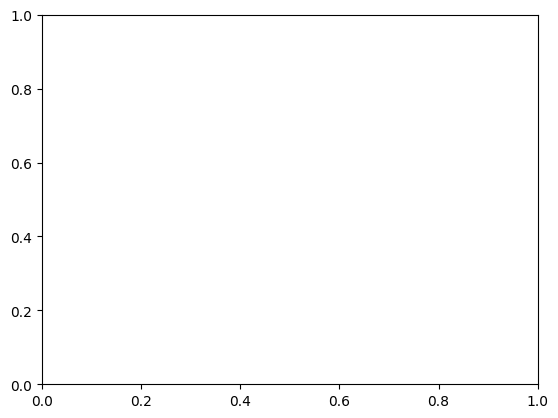

In [16]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

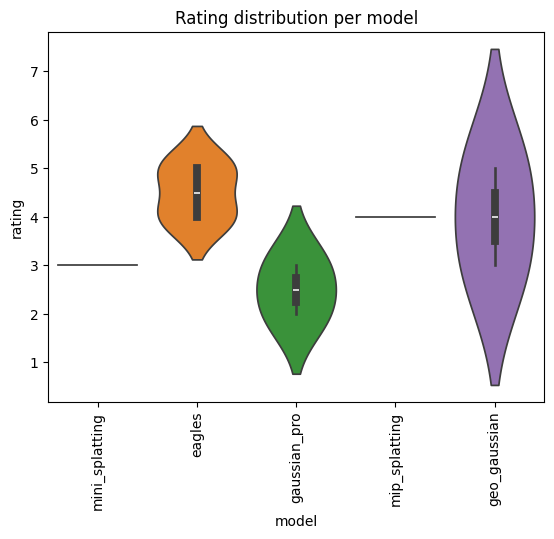

In [96]:
sns.violinplot(df_ratings_truck, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.xticks(rotation=90)
plt.show()